In [492]:
import pandas as pd
import glob
from itertools import product, combinations
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np

### To dos:
- Performance:
    - Loss in precision, but not dramatic (look at qualitative examples...)
    - Interesting that loss is highest for punctuation (less generic but wrong, vs generic)
    - Some interesting error, especially at word boundaries - but also others (categorize error types)
- Uncertainty
    - Entropy and surprisal increase
    - Model is unable to use context to decrease uncertainty
    - More flat distribution

## Read in data and plot

In [766]:
logs = glob.glob('outputs/narratives_top5/*')
logs = [l for l in logs if '_100_' not in l]

In [767]:
metrics = ['is_true_top', 'is_true_in_top_5', 'is_true_in_top_10', 
           'loss', 'surprisal', 'entropy']

In [768]:
for i, l in enumerate(logs):
    ldf = pd.read_csv(l, sep='\t', index_col=0)
    if i % 100 == 0:
        print(f'{i} of {len(logs)}')
    if l == logs[0]:
        all_logs = ldf
    else:
        all_logs = pd.concat([all_logs, 
                              ldf], ignore_index=True)
all_logs['is_true_top'] = (all_logs['target'] == all_logs['top_predicted']).astype(int)
all_logs['surprisal'] = -np.log2(all_logs['prob_true'])
all_logs = all_logs.rename({'top_5': 'is_true_in_top_5', 
                            'top_10': 'is_true_in_top_10'}, axis=1)
all_logs['case_sensitive'] = all_logs['case_sensitive'].replace({'transcript': 'baseline', 
                                                                 'align_upper': '- punctuation',
                                                                 'align_lower_nounk': '- casing',
                                                                 'align_lower_unk': '- casing noised'})

0 of 728
100 of 728
200 of 728
300 of 728
400 of 728
500 of 728
600 of 728
700 of 728


In [771]:
aggs = all_logs.groupby(['case_sensitive', 
                         'model', 
                         'context_size', 
                         'dataset'])[metrics+['prob_predicted']].mean().reset_index()

In [772]:
datasets = all_logs.dataset.unique().tolist()
context_size = all_logs.context_size.unique().tolist()
types = ['baseline', '- punctuation', '- casing', '- casing noised']

Plot overall behavior in all four cases

In [773]:
refs = aggs[aggs['case_sensitive']=='baseline']
ds = []
for d in datasets:
    for t in types[1:]:
        a = aggs[(aggs['dataset']==d) & (aggs['case_sensitive']==t)].sort_values(by='context_size')
        r = refs[(refs['dataset']==d)].sort_values(by='context_size')
        for m in metrics:
            a[m] = a[m].values-r[m].values
        ds.append(a)
ds = pd.concat(ds)

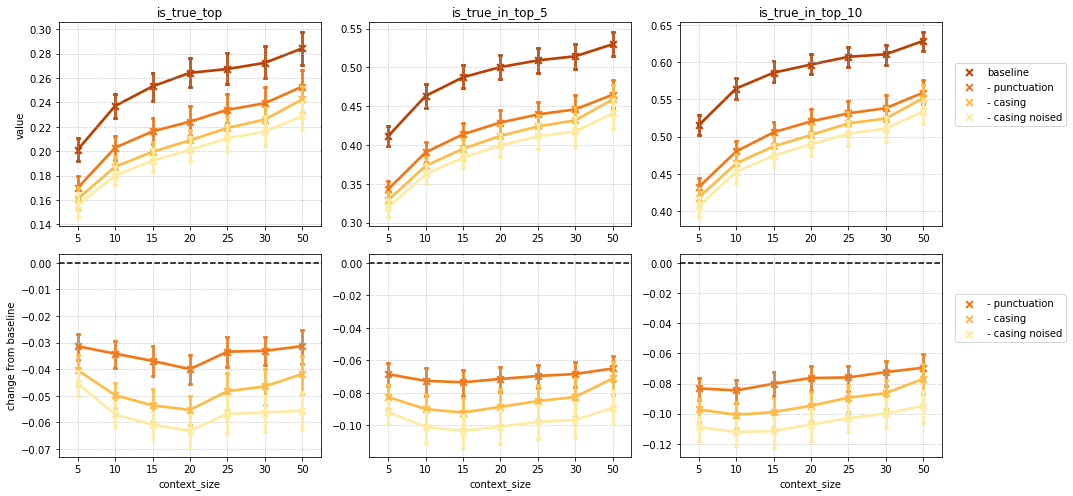

In [774]:
fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(15,7)) # 7
for i, m in enumerate([m for m in metrics if 'top' in m]):
    sns.pointplot(data=aggs, 
                  x='context_size', 
                  y=m, 
                  hue='case_sensitive', 
                  ax=ax[0,i],
                  hue_order=types,
                  palette='YlOrBr_r', 
                  markers='x', 
                  capsize=.05) # add row=model or hue=model
    ax[0,i].set_ylabel('')
    ax[0,i].set_xlabel('')
    if i in [0]:
        ax[0,i].set_ylabel('value')
    ax[0,i].set_title(m)
    if i!=2:
        ax[0,i].get_legend().remove()
    else:
        ax[0,i].legend(bbox_to_anchor=(1.05, .80), 
                     loc=2, 
                     borderaxespad=0.)
    ax[0,i].grid(linestyle='dotted')
for i, m in enumerate([m for m in metrics if 'top' in m]):
    sns.pointplot(data=ds, 
                  x='context_size', 
                  y=m, 
                  hue='case_sensitive', 
                  ax=ax[1,i],
                  hue_order=types[1:],
                  palette=sns.color_palette("YlOrBr_r", 4)[1:], 
                  markers='x', 
                  capsize=.05)
    ax[1,i].set_ylabel('')
    if i!=2:
        ax[1,i].get_legend().remove()
    else:
        ax[1,i].legend(bbox_to_anchor=(1.05, .80), 
                     loc=2, 
                     borderaxespad=0.)
    ax[1,i].axhline(0.0, color='black', linestyle='dashed')
    ax[1,i].grid(linestyle='dotted')
    if i in [0]:
        ax[1,i].set_ylabel('change from baseline')
plt.tight_layout()
plt.show()

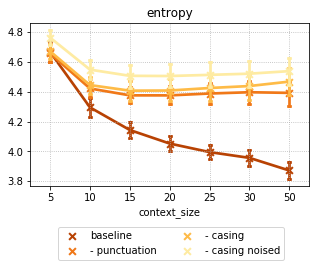

In [852]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(5,3)) # 7
for i, m in enumerate(['entropy']):
    sns.pointplot(data=aggs, 
                  x='context_size', 
                  y=m, 
                  hue='case_sensitive', 
                  ax=ax,
                  hue_order=types,
                  palette='YlOrBr_r', 
                  markers='x', 
                  capsize=.05) # add row=model or hue=model
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.set_xlabel('context_size')
    ax.set_title(m)
    ax.legend(bbox_to_anchor=(.1, -.25), 
                     loc=2, 
                     borderaxespad=0., 
                     ncol=2)
    ax.grid(linestyle='dotted')

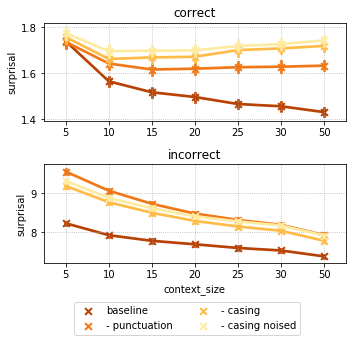

In [841]:
f, ax = plt.subplots(nrows=2, figsize=(5,5))
sns.pointplot(data=all_logs[all_logs['is_true_top']==0],
              x='context_size', 
              y='surprisal', 
              hue='case_sensitive', 
              hue_order=types,
              palette='YlOrBr_r', 
              markers='x', ax=ax[1])
sns.pointplot(data=all_logs[all_logs['is_true_top']==1],
              x='context_size', 
              y='surprisal', 
              hue='case_sensitive', 
              hue_order=types,
              palette='YlOrBr_r', 
              markers='x', ax=ax[0])
for a in ax:
    a.grid(linestyle='dotted')  
ax[0].get_legend().remove()
ax[1].set_title('incorrect')
ax[0].set_xlabel('')
ax[1].legend(bbox_to_anchor=(.1, -.4), 
             loc=2, 
             borderaxespad=0., 
             ncol=2)
ax[0].set_title('correct')
plt.tight_layout()
plt.show()

### Pairwise correlations

In [777]:
from itertools import combinations
pairs = list(combinations(types, 2))

In [778]:
outs = []
for d in datasets:
    for c in context_size:
        for p in pairs:
                ds = all_logs[all_logs['dataset']==d]
                ds = ds[ds['context_size']==c]
                p1 = ds[ds['case_sensitive']==p[0]]
                p2 = ds[ds['case_sensitive']==p[1]]
                for m in metrics:
                    cc = np.corrcoef(p1[m], p2[m])[0,1]
                    outs.append((m,d,c,p[0],p[1],cc))
outd = pd.DataFrame(outs, 
                    columns=['metric',
                             'dataset',
                             'context',
                             'type0',
                             'type1',
                             'corr'])

In [779]:
ags = outd.groupby(['metric', 'context',
                    'type0', 'type1'])['corr'].mean().reset_index()
ags = ags[ags['type0']=='baseline'].drop('type0', axis=1)

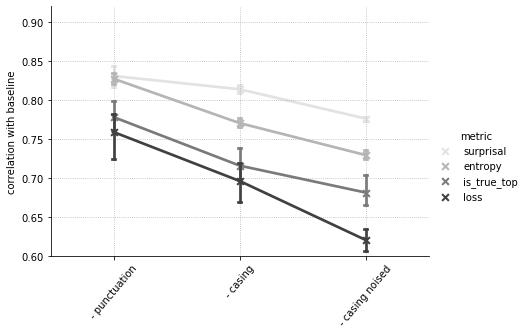

In [780]:
sns.catplot(data=ags[ags['metric'].isin(['surprisal', 'entropy', 
                                         'is_true_top', 'loss'])], hue='metric', 
            x='type1', y='corr', 
            kind='point', 
            order=['- punctuation', '- casing', '- casing noised'], 
            palette=sns.color_palette("Greys", 4),
            hue_order=['surprisal', 'entropy', 'is_true_top', 'loss'], 
            height=4, aspect=1.5, 
            markers='x',
            capsize=.02)
plt.ylim(.6,.92)
plt.xlabel('')
plt.ylabel('correlation with baseline')
plt.xticks(rotation=50)
plt.grid(linestyle='dotted')
plt.show()

In [781]:
all_logs['id'] = all_logs.groupby(['dataset', 
                                   'case_sensitive',
                                   'context_size']).cumcount()+1;

In [782]:
viz = all_logs.pivot(index=['dataset', 'model', 'context_size', 'id'], 
                     columns='case_sensitive', 
                     values=['top_predicted', 'context']).reset_index()
viz.columns = ['dataset', 'model', 'context_size', 'id', 
               '- casing', '- casing noised', '- punctuation', 'baseline',
               '- casing context', '- casing noised context', 
               '- punctuation context', 'baseline context']
viz = viz[['dataset', 'model', 'context_size', 'id', 
           'baseline', '- punctuation', '- casing', '- casing noised', 
           'baseline context', '- punctuation context', 
           '- casing context',  '- casing noised context']]

In [791]:
pd.options.display.max_colwidth = 300
display(viz[(viz['baseline']!=viz['- punctuation']) & (viz['- casing']!=viz['- punctuation'])].sample(n=20).iloc[:,2:30])

,context_size,id,baseline,- punctuation,- casing,- casing noised,baseline context,- punctuation context,- casing context,- casing noised context
193266,20,253,but,.,and,and,"idea what the prices are every place else in the world?"" ""Yeah, eight dollars for a candy bar ""That's fair,",idea what the prices are every place else in the world Yeah eight dollars for a candy bar That's fair,idea what the prices are every place else in the world yeah eight dollars for a candy bar that's fair,idea what the prices are every place else in the world yeah eight dollars for a candy bar that's fair
111649,30,1574,human,real,human,and,"between humans and non humans, and I, I did not know how to negotiate this. There is no category in our language, except a mythical one, for something that's not",between humans and non humans and I I did not know how to negotiate this There is no category in our language except a mythical one for something that's not,between humans and non humans and i i did not know how to negotiate this there is no category in our language except a mythical one for something that's not,between humans and non humans and i i did not know how to negotiate this there is no category in our language except a mythical one for something that's <unk>
63834,10,1419,',",",i,i,"He sized me up in my driveway, and I thought,",He sized me up in my driveway and I thought,he sized me up in my driveway and i thought,he sized me up in my driveway and i thought
39340,25,6323,looks,'s,.,.,"The test sits alone in her basket. At the cashier's, she opens her purse and Margaret's face stares at her from the flier. Haunted, Clara",The test sits alone in her basket At the cashier's she opens her purse and Margaret's face stares at her from the flier Haunted Clara,the test sits alone in her basket at the cashier's she opens her purse and margaret's face stares at her from the flier haunted clara,the test sits alone in her basket at the cashier's she opens her purse and margaret's face stares at her from the flier haunted clara
190123,20,189,idea,end,table,end,"know, Neal's a real good cook,"" he said, eying his father above the menu. Scott gave a snort at the",know Neal's a real good cook he said eying his father above the menu Scott gave a snort at the,know neal's a real good cook he said eying his father above the menu scott gave a snort at the,know <unk> a real good cook he said <unk> his father above the menu scott gave a snort at the
65434,15,1485,want,don,want,want,to juggle in my life. There's a lot more weight in my life. I just,to juggle in my life There's a lot more weight in my life I just,to juggle in my life there's a lot more weight in my life i just,to juggle in my life there's a lot more weight in my life i just
58947,15,301,not,�,not,not,"for you Leonard turned to Sheldon as Penny walked away. ""What did she mean, she’s",for you Leonard turned to Sheldon as Penny walked away What did she mean she’s,for you leonard turned to sheldon as penny walked away what did she mean she's,for you leonard turned to sheldon as penny walked away what did she mean she's
272477,10,2539,in,my,the,the,"I don't blame you. This is crazy, but it fits",I don't blame you This is crazy but it fits,i don't blame you this is crazy but it fits,i don't blame you this is crazy but it fits
289590,50,2577,we,they,and,and,"propaganda machine. What? I don't know who they are or how they've done it, but somehow they've taken Tylertown over. Hypnosis. Hypnosis, drugs, maybe some kind of a ray or something. However they do it, what happens is that they let us live through a single day. During that day,",propaganda machine What I don't know who they are or how they've done it but somehow they've taken Tylertown over Hypnosis Hypnosis drugs maybe some kind of a ray or something However they do it what happens is that they let us live through a single day During that day,propaganda machine what i don't know who they are or how they've done it but somehow they've taken tylert

### Examples from each dataset type

In [527]:
all_logs[all_logs['dataset']=='seinfeld'][all_logs['id']==9][all_logs['target']!=all_logs['orig_wd']][all_logs['context_size']==20]

<ipython-input-527-92a9e3d4c693>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  all_logs[all_logs['dataset']=='seinfeld'][all_logs['id']==9][all_logs['target']!=all_logs['orig_wd']][all_logs['context_size']==20]
<ipython-input-527-92a9e3d4c693>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  all_logs[all_logs['dataset']=='seinfeld'][all_logs['id']==9][all_logs['target']!=all_logs['orig_wd']][all_logs['context_size']==20]


,dataset,model,context,target,orig_wd,top_predicted,loss,entropy,prob_true,prob_predicted,top_5,top_10,context_size,case_sensitive,is_top_true,surprisal,id
133281,seinfeld,gpt2,their suitcases George walked quickly grimacing as he scanned the signs to figure out which way to go A man,passing,passing,in,5.259786,5.365333,0.000653,0.115491,0,0,20,- punctuation,0,10.579862,9
463500,seinfeld,gpt2,their suitcases george walked quickly <unk> as he scanned the signs to figure out which way to go a man,passing,passing,was,5.821630,5.605934,0.000472,0.057064,0,0,20,- casing noised,0,11.049943,9
629980,seinfeld,gpt2,"their suitcases. George walked quickly, grimacing as he scanned the signs to figure out which way to go. A man",passing,passing,in,3.871184,4.950641,0.000677,0.142569,0,0,20,baseline,0,10.529531,9
1120866,seinfeld,gpt2,their suitcases george walked quickly grimacing as he scanned the signs to figure out which way to go a man,passing,passing,was,5.117067,4.767756,0.000252,0.125748,0,0,20,- casing,0,11.956021,9


### Visualize number of unique words

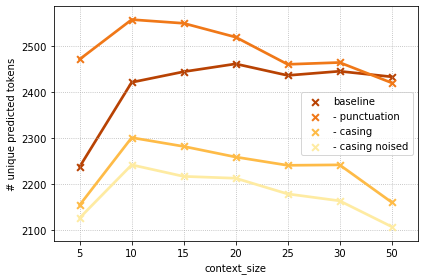

In [715]:
sns.pointplot(data=all_logs.groupby(['context_size', 'case_sensitive']).top_predicted.nunique().reset_index(),
              x='context_size', y='top_predicted', 
              hue='case_sensitive', 
              palette='YlOrBr_r', 
              markers='x', hue_order=['baseline',
                                     '- punctuation',
                                     '- casing',
                                     '- casing noised'])
plt.legend(title=None)
plt.grid(linestyle='dotted')
plt.ylabel('# unique predicted tokens')
plt.ylabel
plt.tight_layout()

### Visualize distributions of probabilities (for top vs. bottom values)

In [664]:
dslist = []
fs = glob.glob('outputs/narratives_raw/*')
for f in fs:
    dslist.append(pd.read_csv(f, sep='\t', index_col=0))
raws = pd.concat(dslist)

In [665]:
raws['case_sensitive'] = raws['case_sensitive'].replace({'transcript': 'baseline', 
                                                         'align_upper': '- punctuation',
                                                         'align_lower_nounk': '- casing',
                                                         'align_lower_unk': '- casing noised'})

In [700]:
labels = ['top_1', '2_to_5', '5_to_10', '10_to_100', '100_to_1000', 'bottom_1000']

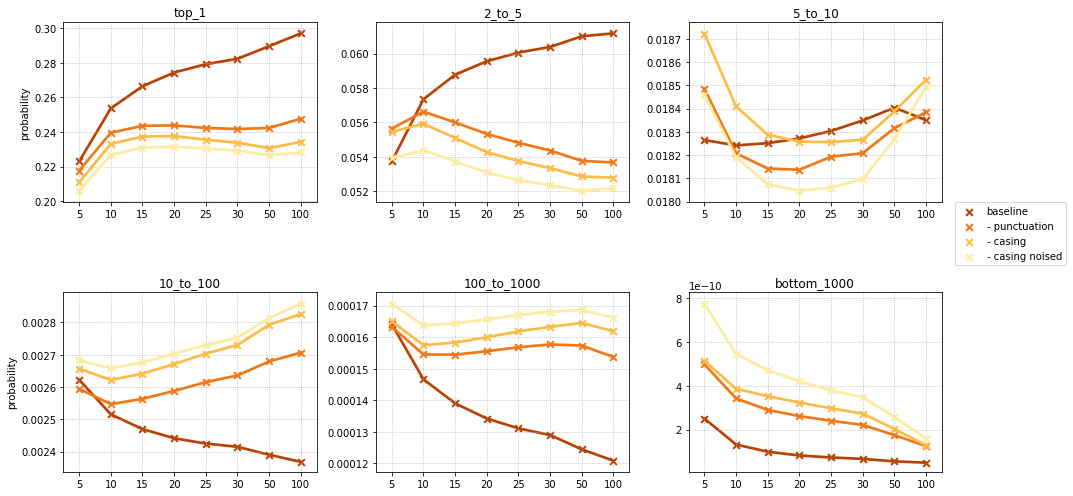

In [864]:
fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(15,7))
idx = list(product(range(2), range(3)))
for i,c in enumerate(['to_1', 'to_5', 'to_10', 'to_100', 'to_1000', 'bottom_1000']):
    sns.pointplot(data=raws,
                  x='context_size',
                  hue='case_sensitive', 
                  palette='YlOrBr_r',
                  y=c, 
                  markers='x',
                  hue_order=['baseline', 
                             '- punctuation', 
                             '- casing', 
                             '- casing noised'], 
                  ax=ax[idx[i]], ci=None)
    if i!=2:
        ax[idx[i]].get_legend().remove()
    else:
        ax[idx[i]].legend(bbox_to_anchor=(1.05, .0), 
                     loc=2, 
                     borderaxespad=0.)
for i in range(6):
    ax[idx[i]].grid(linestyle='dotted')
    ax[idx[i]].set_xlabel('')
    ax[idx[i]].set_title(labels[i])
    if i in [0,3]:
        ax[idx[i]].set_ylabel('probability')
    else:
        ax[idx[i]].set_ylabel('')
plt.tight_layout()
plt.show()

### What the model gets wrong

In [578]:
p = all_logs[all_logs['case_sensitive']=='- punctuation']
b = all_logs[all_logs['case_sensitive']=='baseline']

In [579]:
merged = b.merge(p[['context', 'target', 'context_size', 'dataset', 'top_predicted', 'id', 'is_top_true']], on=['context_size', 'dataset', 'id'])

In [732]:
merged[(merged['is_top_true_x']==1) & (merged['is_top_true_y']==0)][['context_x', 
                                                                     'top_predicted_x', 
                                                                     'top_predicted_y']].sample(n=20)

,context_x,top_predicted_x,top_predicted_y
238724,"up!?"" a man behind them",shouted,","
143678,"all glass. Frosted glass Sasha's self conscious as she locks it behind her. The bathroom: White granite. Hasn't been cleaned for a while. She puts in her diaphragm. Alexander's shadow stops outside the door. ""Red or White?"" She tries to think of something sassy, but says ""Red, thanks Then adds:","""",a
124446,"The ceiling in Sasha's room is finally fixed. Steven sits in front of his Scotch. On the TV the Middle East, India, Wars, Earthquakes, Crashes. He can't stand the news.",He,of
6203,"Sherlock about how he knew everything about, uh, having, about Watson having, like, an estrange estrange estranged brother, who left his wife, and, or is alcoholic, and how he knew that he was an army doctor from Afghanistan. Um, so, Sherlock explains everything. I didn’t catch every little deta...",said,could
12815,"is? I can't sleep He looks so distraught. ""I always miss the signs,"" says Steven.","""",\n
87294,"Overview Effect that most every astronaut describes, which is really the series of epiphanies that you get from this great,",wonderful,series
151401,"the house, Gary's upstairs. Left the lights on, their bottles",of,and
104118,"was abnormal. And, uh, another kind of thing happened at that time, too, which was that I began to publish my first games. I wrote",a,and
107963,"man sitting in front of what we can assume is his therapist. And, um, they’re talking. She says something about him still having trust issues,",and,","
103377,"get, you know, which isn't that depressed really. But, uh, within a couple of days, I, you know, I resolved myself to the following thought.",I,:


In [796]:
merged[(merged['is_top_true_x']==0) & (merged['is_top_true_y']==1) & (merged['context_size']==15)][['context_x', 
                                                                     'top_predicted_x', 
                                                                     'top_predicted_y']].sample(n=20)

,context_x,top_predicted_x,top_predicted_y
72437,wear capes. I’m from the place that produces wimps. And this really raises the question,:,of
230054,"was a question about whether she even knew I existed. So, I saw her there",.,and
177098,"Um, oh, I never mentioned earlier, but, so Watson, he has a, uh, his leg",",",is
16140,"chair. ""You cannot save people,"" Jeannie said that night in LA, ""You cannot save the",world,people
165305,"dream. He sleeps the rest of the night. In the morning, the boy's father wakes",him,up
13017,"in her face, ""What do I want?!"" She pushes him back with all of her",might,strength
240282,"a scene, takes place inside the tent. And then, um, another figure approaches the tent",",",and
16742,He's Sikh. His turban blocks her view of the asphalt. Clara watches out of the,corner,window
177199,"have, or sorry, Sherlock unzips it, looks down, that’s when we first see him. And",then,he
8542,red plastic bowls wine in blue plastic. The colors don't match and the cups are,not,too


### Plot number of trials where models produce the same predictions as baseline

In [787]:
refs_long = all_logs[all_logs['case_sensitive']=='baseline']
ds_long = []
for d in datasets:
    for t in types[1:]:
        a = all_logs[(all_logs['dataset']==d) & (all_logs['case_sensitive']==t)].sort_values(by='context_size')
        r = refs_long[(refs_long['dataset']==d)].sort_values(by='context_size')
        a['difference'] =( a['top_predicted'].str.lower().values == r['top_predicted'].str.lower().values).astype(int)
        ds_long.append(a)
ds_long = pd.concat(ds_long)

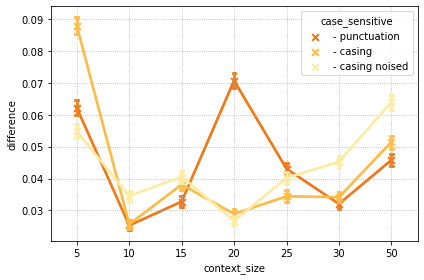

In [788]:
for i, m in enumerate(['difference']):
    sns.pointplot(data=ds_long, 
                  x='context_size', 
                  y=m, 
                  hue='case_sensitive', 
                  hue_order=types[1:],
                  palette=sns.color_palette("YlOrBr_r", 4)[1:], 
                  markers='x', 
                  capsize=.05)
plt.grid(linestyle='dotted')
plt.tight_layout()
plt.show()

In [ ]:
# Others were not so Oh there, I lost a word. One that would mean "careful to obey the rules". The	other	rules
# little networking opportunity. That's what this meeting is She touches her neck. She wants to protect herself. She wants to hide. Alexander hands Margaret his card. "Have Sasha call me,"	he	back
# this hint and I describe again um one of my mother's recipes for cornbread dressing, and I took care on the air to say not bread, not white bread dressing,	but	.
# two guys, pretty young, um, walking in the rain. One	of	guy
# like, room, I guess, and, um, he puts it down at first because no one’s there. And he notices like that voodoo doll that she had, um, stab, she had been stabbing in the tent. And then, uh, he looks fairly confused and, um, kind of concerned and then he,	uh	goes
# prepared to see Sophia. Martin called Sophia’s cell, and finally convinced her to come with	him	her
# or you snubbed me on the bus. Today, the same	thing	day
# him. He still has a cat in his step. My new apartment looks great, Maggie,"	he	's